## Classify with One VS All

In [7]:
import numpy as np
import scipy

# to save data
import pickle

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics.pairwise import pairwise_kernels
from scipy.optimize import minimize
from scipy.spatial.distance import hamming

import matplotlib.pyplot as plt
%matplotlib inline

from mySVM_class import *
from oneVSall import *


In [20]:
def m_classes(l,n,m):
    
    #l: samples per class
    #n: dimension
    #m: number of classes
    
    centers = 20*np.random.rand(m,n)-10 #create the centers of the classes
    data = np.zeros((1, n))
    labels = np.zeros(l*m)
    for i in range(m):
        center = centers[i]
        # print(np.shape(data), np.shape(np.random.normal(loc=center, scale=1.0, size=(l, n))))
        
        data = np.concatenate((data,np.random.normal(loc=center, scale=1.0, size=(l, n))), axis = 0)
        
    for i in range(m):
        labels[(i*l):((i+1)*l)]=i 
    
    return data[1:], labels, centers

Generate image for presentation

In [71]:
perclass = 15
image_data, image_labels, image_centers = m_classes(perclass, 2, 3)
label0 = image_data[:perclass]
label1 = image_data[perclass:2*perclass]
label2 = image_data[2*perclass:3*perclass]


svm0vsall = mySVM(kernel = scalar_product)
svm0vsall.fit(image_data, np.concatenate((np.ones(perclass), -np.ones(2*perclass))))
w0 = svm0vsall.w
b0 = svm0vsall.b
m0 = -w0[0] / w0[1]

svm1vsall = mySVM(kernel = scalar_product)
svm1vsall.fit(image_data, np.concatenate((-np.ones(perclass), np.ones(perclass), -np.ones(perclass))))
w1 = svm1vsall.w
b1 = svm1vsall.b
m1 = -w1[0] / w1[1]
              
svm2vsall = mySVM(kernel = scalar_product)
svm2vsall.fit(image_data, np.concatenate((-np.ones(2*perclass), np.ones(perclass))))
w2 = svm2vsall.w
b2 = svm2vsall.b
m2 = -w2[0] / w2[1]

#baycenters
barycenter0 = np.mean(label0, axis=0)
barycenter1 = np.mean(label1, axis=0)
barycenter2 = np.mean(label2, axis=0)


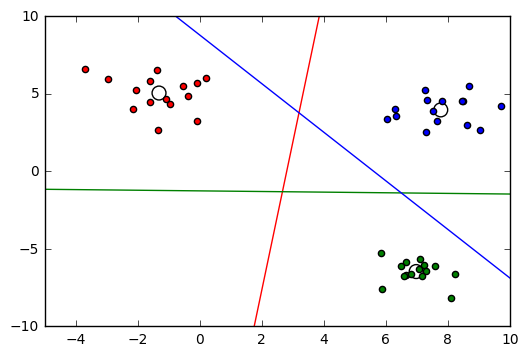

In [77]:
onevsall_fig = plt.figure()
plt.scatter([barycenter0[0], barycenter1[0], barycenter2[0]], [barycenter0[1], barycenter1[1], barycenter2[1]], s = 100, facecolors = 'none')
plt.scatter(label0[:, 0], label0[:, 1], facecolors = 'red')
plt.scatter(label1[:, 0], label1[:, 1], facecolors = 'green')
plt.scatter(label2[:, 0], label2[:, 1], facecolors = 'blue')
plt.xlim([-5, 10])
plt.ylim([-10, 10])

x = np.linspace(-15, 10, 100)
y0 = m0 * x - b0 / w0[1]
y1 = m1 * x - b1 / w1[1]
y2 = m2 * x - b2 / w2[1]

plt.plot(x, y0, 'r', x, y1, 'g', x, y2,'b')
onevsall_fig.savefig('onevsall_examplegraphic.png')

In [26]:
image_labels

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.])

In [9]:
l=400;
n=10;
m=10;
toy_data, toy_labels, toy_centers = m_classes(l, n, m)
# toy_data_set

In [28]:
ecoc_labels, list_supp_ind, list_alpha, list_b, list_w, list_kernel, code_words, barycenters =oneVSall(toy_data[::2], toy_labels[::2], num_classifiers=m)

ValueError: not enough values to unpack (expected 8, got 7)

NameError: name 'list_w' is not defined

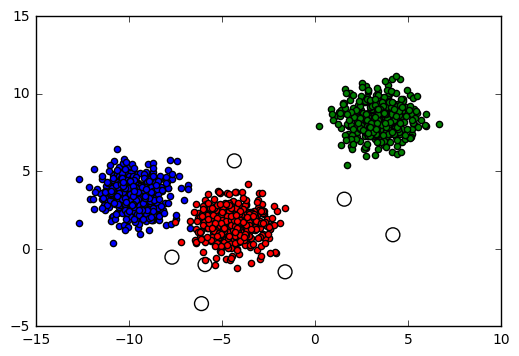

In [11]:
plt.scatter(toy_centers[:,0],  toy_centers[:,1], s=100, facecolors = 'none')
plt.scatter(toy_data[:l, 0], toy_data[:l, 1])
plt.scatter(toy_data[l:2*l, 0], toy_data[l:2*l, 1], facecolors='red')
plt.scatter(toy_data[2*l:3*l, 0], toy_data[2*l:3*l, 1], facecolors='green')

xs = np.linspace(-10, 10, 100)
ys = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(xs, ys)

for i in range(m):
    np.dot(list_w[i],[1,1])
    print(list_w[i], list_b[i])
    Z = np.array([[ np.dot(list_w[i],np.array([x,y]))+list_b[i] for x in xs] for y in ys])
    Z = np.reshape(Z, (np.shape(Z)[0], np.shape(Z)[1]))
    #plt.plot([0, list_b[2]], [[1,1], np.dot(list_w[2],[1,1])+list_b[0]], 'k-', color = 'r
    CS = plt.contour(X, Y, Z, levels = [0])
    plt.clabel(CS, colors = 'k', fontsize=14)


In [12]:
toy_labels

array([ 0.,  0.,  0., ...,  9.,  9.,  9.])

In [13]:
predicted_labels = predict_oneVSall(toy_data[1::2], toy_data[::2], ecoc_labels, list_supp_ind, list_alpha, list_b, list_kernel, code_words, barycenters, num_classifiers=m)
print("number of correctly classified labels: ", sum(predicted_labels.astype(int)==toy_labels[1::2].astype(int)), 
      " out of ", np.shape(toy_data[1::2])[0]);
predicted_labels

NameError: name 'ecoc_labels' is not defined

### Hier gehts los.

In [14]:
train = pd.read_csv('Data/train.csv')

In [15]:
images = ["%s%s" %("pixel",pixel_no) for pixel_no in range(0,28**2)]
train_images = np.array(train[images], dtype=np.float)/100

train_labels = np.array(train['label'])
#label0 = np.array([1 if i==0 else -1 for i in train_labels])
len(train_images)

42000

In [4]:
kernel = scalar_product
number_of_im = 10000;
number_of_test_data = 1000
train_images_test = train_images[:number_of_im]
train_labels_test = train_labels[:number_of_im]
np.shape(train_images_test)[1]

lamb=0.00014;
penalty = 1./(2*lamb*number_of_im);
oneVSall_labels, list_supp_ind, list_alpha, list_b, list_kernel, code_words, barycenters = oneVSall(
    train_images_test,
    train_labels_test,
    kernel = kernel,
    penalty=penalty
)
# oneVSall_labels, list_supp_ind, list_alpha, list_b, list_kernel, code_words, barycenters=pickle.load(open ("trained_oneVSall_"+str(number_of_im)+".dat", "rb"))

# "unknown" data to be classified
test_data = train_images[number_of_im:number_of_im+number_of_test_data]

# call predict function
predicted_labels_test, list_oneVsall_unique_index, counter_onevsall, counter_barycenter = predict_oneVSall(
    train_images[number_of_im:number_of_im+number_of_test_data], 
    train_images[:number_of_im], 
    oneVSall_labels, list_supp_ind, 
    list_alpha, 
    list_b, list_kernel, 
    code_words, 
    barycenters
)
predicted_labels_test = predicted_labels_test.astype(float)
# print("predicted labels: ", predicted_labels_test)

# get actual labels
train_labels_test=train_labels[number_of_im:number_of_im+number_of_test_data]
train_labels_test = train_labels_test.astype(float)
# print("actual labels: ", train_labels_test)

print("number of correctly classified labels: ", sum(predicted_labels_test.astype(int)==train_labels_test.astype(int)), 
      " out of ", number_of_test_data);
print("number of correctly classified labels by one vs all: ", sum((predicted_labels_test.astype(int))[list_oneVsall_unique_index]==train_labels_test.astype(int)[list_oneVsall_unique_index]), 
      " out of ", number_of_test_data);
# check if there is are a couple of classifiers who make more mistakes than others
# then we could possibly change some of the parameters

counter one Vs all classified  687
counter barycenter classified  313
number of correctly classified labels:  675  out of  1000
number of correctly classified labels by one vs all:  646  out of  1000


In [5]:
#Ergebnisse in text-Datei schreiben

file = open('oneVsall_results.txt','a') 
 
file.write('kernel: ' + str(kernel.__name__) + '\n') 
file.write('number of training points: ' + str(number_of_im)+ '\n') 
file.write('number of test points: ' + str(number_of_test_data) + '\n') 
file.write("counter one Vs all classified " + str(counter_onevsall) + '\n')
file.write("counter barycenter classified " + str(counter_barycenter) + '\n')
file.write("number of correctly classified labels: " + str(sum(predicted_labels_test.astype(int)==train_labels_test.astype(int))) + 
      " out of " + str(number_of_test_data) + '\n')
file.write("number of correctly classified labels by one vs all: " + str(sum((predicted_labels_test.astype(int))[list_oneVsall_unique_index]==train_labels_test.astype(int)[list_oneVsall_unique_index])) + 
      " out of " + str(number_of_test_data) + '\n \n \n')

file.close() 